In [27]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

The hidden message size is (363, 125, 3)
The original image size is (667, 1000, 3)


Text(0.5, 1.0, 'Hidden Message')

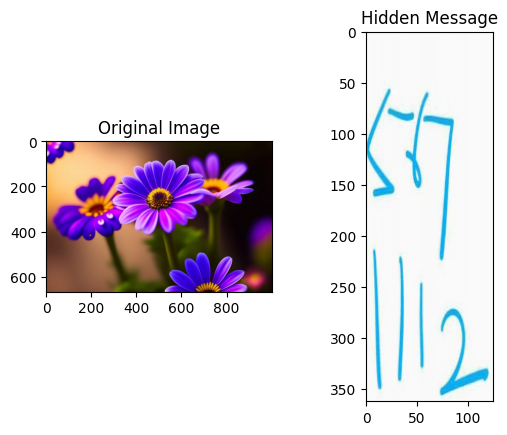

In [66]:
tulip = plt.imread('tulip.jpg')
message = plt.imread('message.jpg')

scale = (message.shape[1] / tulip.shape[1])*8
message = resize(message, (message.shape[0], message.shape[1]/scale, 3))

print(f"The hidden message size is {message.shape}")
print(f"The original image size is {tulip.shape}")

message = (message * 255).astype(np.uint32)

plt.subplot(1, 2, 1)
plt.imshow(tulip)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(message)
plt.title("Hidden Message")



In [29]:
def encode_LSB_match(original_img, hidden_img):

    new_original_img = np.copy(original_img)

    hidden_img_red = []
    hidden_img_green = []
    hidden_img_blue = []
    
    flat_red = new_original_img[:, :, 0].flatten()
    flat_green = new_original_img[:, :, 1].flatten()
    flat_blue = new_original_img[:, :, 2].flatten()
    
    flat_hid_red = hidden_img[:, :, 0].flatten()
    flat_hid_green = hidden_img[:, :, 1].flatten()
    flat_hid_blue = hidden_img[:, :, 2].flatten()
    
    mod_flat_red = np.copy(flat_red)
    mod_flat_green = np.copy(flat_green)
    mod_flat_blue = np.copy(flat_blue)
    
    for i in range(flat_hid_red.shape[0]):
        hidden_img_red.append(format(flat_hid_red[i], '08b'))
        
    for i in range(flat_hid_green.shape[0]):
        hidden_img_green.append(format(flat_hid_green[i], '08b'))
        
    for i in range(flat_hid_blue.shape[0]):
        hidden_img_blue.append(format(flat_hid_blue[i], '08b'))
            
    k = 0
    for x, y, z in zip(hidden_img_red, hidden_img_green, hidden_img_blue):
        for i in range(8):
        #     print(type(x[i]))
            if int(x[i]) != (mod_flat_red[k] & 1):
                mod_flat_red[k] = (254 if flat_red[k] == 255 else mod_flat_red[k] + 1)

            if int(y[i]) != (mod_flat_green[k] & 1):
                mod_flat_green[k] = (254 if flat_green[k] == 255 else mod_flat_green[k] + 1)

            if int(z[i]) != (mod_flat_blue[k] & 1):
                mod_flat_blue[k] = (254 if flat_blue[k] == 255 else mod_flat_blue[k] + 1)

            k += 1
            
    mod_flat_red = mod_flat_red.reshape(original_img.shape[0], original_img.shape[1])
    mod_flat_green = mod_flat_green.reshape(original_img.shape[0], original_img.shape[1])
    mod_flat_blue = mod_flat_blue.reshape(original_img.shape[0], original_img.shape[1])
    
    stego_img = np.zeros((original_img.shape[0], original_img.shape[1], 3), dtype=np.uint8)
    stego_img[:, :, 0] = mod_flat_red
    stego_img[:, :, 1] = mod_flat_green
    stego_img[:, :, 2] = mod_flat_blue
    
    
    return stego_img

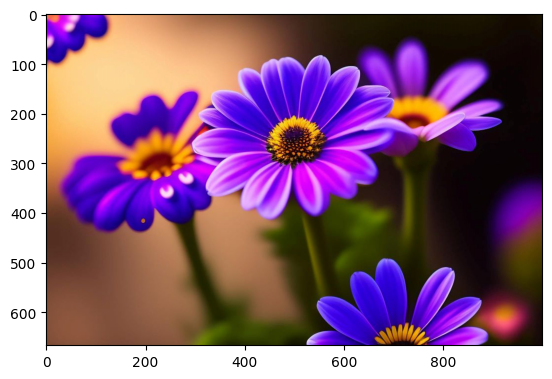

In [37]:
stego_img = encode_LSB_match(tulip, message)
diff_img = stego_img - tulip
# print(diff_img)
plt.imshow(stego_img)
diff_img = diff_img[0:363, : , :]


In [64]:
def Decode_LSB_Match(original_img, diff_img):
    a , b , c = diff_img.shape
    sz = int(b/8)
    
    new_original_img = np.copy(original_img)
    
    diff_img_red = diff_img[:, :, 0].flatten()
    diff_img_green = diff_img[:, :, 1].flatten()
    diff_img_blue = diff_img[:, :, 2].flatten()
    
    flat_red = new_original_img[:, :, 0].flatten()
    flat_green = new_original_img[:, :, 1].flatten()
    flat_blue = new_original_img[:, :, 2].flatten()
    
    mod_diff_red = np.zeros(diff_img_red.shape[0]).astype(np.uint8)
    mod_diff_green = np.zeros(diff_img_green.shape[0]).astype(np.uint8)
    mod_diff_blue = np.zeros(diff_img_blue.shape[0]).astype(np.uint8)
    
    for i in range(diff_img_red.shape[0]):
        if diff_img_red[i] != 0:
            mod_diff_red[i] = (1 if flat_red[i] & 1 == 0 else 0)
        else:
            mod_diff_red[i] = flat_red[i] & 1
    
    print(mod_diff_red.shape)        
            
    for i in range(diff_img_green.shape[0]):
        if diff_img_green[i] != 0:
            mod_diff_green[i] = (1 if flat_green[i] & 1 == 0 else 0)
        else:
            mod_diff_green[i] = flat_green[i] & 1
            
    for i in range(diff_img_blue.shape[0]):
        if diff_img_blue[i] != 0:
            mod_diff_blue[i] = (1 if flat_blue[i] & 1 == 0 else 0)
        else:
            mod_diff_blue[i] = flat_blue[i] & 1
            
    hid_img_red = np.zeros((a, sz)).flatten()
    hid_img_green = np.zeros((a, sz)).flatten()
    hid_img_blue = np.zeros((a, sz)).flatten()
    
    for i in range(hid_img_red.shape[0]):
        hid_img_red[i] = int(''.join(map(str, mod_diff_red[i:i+8])), 2)
        hid_img_blue[i] = int(''.join(map(str, mod_diff_blue[i:i+8])), 2)
        hid_img_green[i] = int(''.join(map(str, mod_diff_green[i:i+8])), 2)
        
        
    
    hid_img_red = hid_img_red.reshape(a, sz)
    hid_img_green = hid_img_green.reshape(a, sz)
    hid_img_blue = hid_img_blue.reshape(a, sz)
    
    hidden_img = np.zeros((a, sz, 3), dtype=np.uint32)
    
    hidden_img[:, :, 0] = hid_img_red
    hidden_img[:, :, 1] = hid_img_green
    hidden_img[:, :, 2] = hid_img_blue
    
    return hidden_img
        

(363000,)


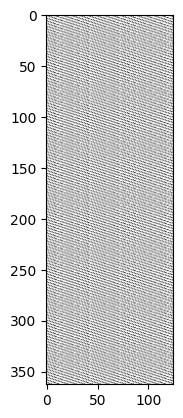

In [65]:
hidden_image = Decode_LSB_Match(tulip, diff_img)

plt.imshow(hidden_image)